# DNN Classification

In [2]:
# preamble
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time

from collections import Counter

from labm8.py import fs
from labm8.py import viz

from keras.models import Sequential
from keras.layers import Input, Dropout, Embedding, merge, LSTM, Dense
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

from scipy.stats import percentileofscore
from scipy.stats.mstats import gmean

from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

import clgen
from clgen import clutil
from clgen.atomizer import CharacterAtomizer, GreedyAtomizer

Using TensorFlow backend.


In [3]:
seed = 7
np.random.seed(seed)

Methods for wrangling data:

In [4]:
def get_2(D):
    """ return np array of shape (len(D), nb_features)"""
    return np.array([
        D["transfer"].values,
        D["wgsize"].values,
    ]).T

def get_4(D):
    """ return np array of shape (len(D), nb_features)"""
    return np.array([
        (D["transfer"].values / (D["comp"].values + D["mem"].values)),  # F1
        (D["coalesced"].values / D["mem"].values),  # F2
        ((D["localmem"].values / D["mem"].values) * D["wgsize"].values),  # F3
        (D["comp"].values / D["mem"].values),  # F4
    ]).T
    
def get_11(D):
    """ return np array of shape (len(D), nb_features)"""
    return np.array([
        D["comp"].values,
        D["rational"].values,
        D["mem"].values,
        D["localmem"].values,
        D["coalesced"].values,
        D["transfer"].values,
        D["wgsize"].values,
        (D["transfer"].values / (D["comp"].values + D["mem"].values)),  # F1
        (D["coalesced"].values / D["mem"].values),  # F2
        ((D["localmem"].values / D["mem"].values) * D["wgsize"].values),  # F3
        (D["comp"].values / D["mem"].values),  # F4
    ]).T

def get_sequences(D, max_seq_len):
    """ return np array of shape (len(D), max_seq_len) """
    for row in D["seq"].values:
        assert(len(row) == max_seq_len)
    data = np.array(D["seq"].values)
    return np.vstack([np.expand_dims(x, axis=0) for x in data])

def get_labels(D):
    """ cpu/gpu to int, return np array of shape (len(D), 1) """
    return np.vstack([np.expand_dims(x, axis=0) for x in D["oracle_enc"]])

def get_y2(D):
    l2 = [x[0] for x in get_labels(D)]
    l1 = [not x for x in l2]
    return np.array(list(zip(l1, l2)), dtype=np.int32)

def get_train_validation_test_splits(D, split=(.6, .2, .2), seed=1):
    """ split dataframe into 3 frames for training, validation, and testing """
    if round(sum(split), 3) != 1.000:  # FIXME
        print(round(sum(split), 3))
    assert(round(sum(split), 3) == 1.000)
    train_split, validation_split, test_split = split
    
    num_synthetic = sum(D["synthetic"].values)
    
    np.random.seed(seed)
    train_msk = np.random.rand(len(D)) < train_split
    
    train = D[train_msk]
    other = D[~train_msk]
    
    test_msk = np.random.rand(len(other)) < split[2] / sum(split[1:])
    test = other[test_msk]
    validation = other[~test_msk]
 
    np.random.seed()  # re-seed RNG
    return train, validation, test

def get_train_validation_test_splits(D, split=(.6, .2, .2), seed=1):
    """ split dataframe into 3 frames for training, validation, and testing.
    synthetics are exclusively for training """
    # TODO: balance benchmark suites in splits
    # TODO: balance labels in splits
    if round(sum(split), 3) != 1.000:  # FIXME
        print(round(sum(split), 3))
    assert(round(sum(split), 3) == 1.0)
    train_split, validation_split, test_split = split
    
    num_synthetic = sum(D["synthetic"].values)
    num_benchmarks = len(D) - num_synthetic
    
    np.random.seed(seed)
    
    if num_benchmarks:
        train_msk = np.logical_or(np.random.rand(len(D)) < train_split, D["synthetic"])
    else:
        train_msk = np.random.rand(len(D)) < train_split
    
    train = D[train_msk]
    other = D[~train_msk]
    
    test_msk = np.random.rand(len(other)) < split[2] / sum(split[1:])
    test = other[test_msk]
    validation = other[~test_msk]

    np.random.seed()  # re-seed RNG
    return train, validation, test

def load_dataframe(platform, source="B", max_seq_len=1000, atomizer=CharacterAtomizer):
    """ load experimental results """
    def escape_suite_name(g):
        """format benchmark suite name for display"""
        c = g.split('-')
        if (c[0] == "amd" or c[0] == "npb" or c[0] == "nvidia" or c[0] == "shoc"):
            return c[0].upper()
        else:
            return c[0].capitalize()
    
    def get_benchmarks(platform):
        B = pd.read_csv(fs.path("classification/{platform}-benchmarks.csv".format(**vars())))
        B["source"] = [escape_suite_name(x) for x in B["benchmark"]]
        B["synthetic"] = [0] * len(B)
        return B

    def get_npb_benchmarks(platform):
        B = get_benchmarks(platform)
        msk = B["source"] == "NPB"
        return B[msk]
    
    def get_synthetics(platform):
        S = pd.read_csv(fs.path("classification/{platform}-clgen.csv".format(**vars())))
        S["source"] = ["CLgen"] * len(S)
        S["synthetic"] = [1] * len(S)
        return S
    
    if source == "B":
        dataframe = get_benchmarks(platform)
    elif source == "S":
        dataframe = get_synthetics(platform)
    elif source == "BS":
        dataframe = pd.concat((get_benchmarks(platform), get_synthetics(platform)))
    elif source == "N":
        dataframe = get_npb_benchmarks(platform)
    elif source == "NS":
        dataframe = pd.concat((get_npb_benchmarks(platform), get_synthetics(platform)))
    else:
        raise Exception

    print("num instances {} ({} synthetic, {} benchmarks)".format(
        len(dataframe),
        sum(dataframe["synthetic"].values),
        len(dataframe) - sum(dataframe["synthetic"].values)))
        
    dataframe["oracle_enc"] = [1 if x == "GPU" else 0 for x in dataframe["oracle"].values]

    # load source code:
    source_dir = fs.path("classification/kernels")
    srcs = []
    for row in dataframe["benchmark"].values:
        inpath = fs.path(source_dir, row + ".cl")
        with open(inpath) as infile:
            src = infile.read()
        if not src.startswith("__kernel void A"):
            print(fs.basename(inpath))
            raise Exception(src)
        srcs.append(src)
        
    print("unique kernels", len(set(srcs)))
    dataframe["src"] = srcs
    dataframe["src_len"] = [len(s) for s in srcs]
    
    # encode and pad sequences:
    atomizer = atomizer.from_text(''.join(dataframe["src"].values))
    
    seqs = [atomizer.atomize(seq) for seq in dataframe["src"].values]
    seq_length = min(max(len(s) for s in seqs), max_seq_len)
    pad_val = atomizer.vocab_size + 1
    dataframe["seq_len"] = [len(s) for s in seqs]
    dataframe["seq"] = list(pad_sequences(seqs, maxlen=seq_length, value=pad_val))
    print("vocab size", atomizer.vocab_size + 1)
    print("pad val", pad_val)
    print("padded seq length", seq_length)
    
    return dataframe, seq_length, atomizer

def get_training_data(dataframe, seed, seq_length, *args, split=(.6, .2, .2), **kwargs):
    train, validation, test = get_train_validation_test_splits(dataframe, seed=seed, split=split)

    x_train_2 = get_2(train)
    x_train_4 = get_4(train)
    x_train_11 = get_11(train)
    x_train_seq = get_sequences(train, seq_length)
    y_train = get_labels(train)
    y2_train = get_y2(train)
    
    x_val_2 = get_2(validation)
    x_val_4 = get_4(validation)
    x_val_11 = get_11(validation)
    x_val_seq = get_sequences(validation, seq_length)
    y_val = get_labels(validation)
    y2_val = get_y2(validation)
    
    x_test_2 = get_2(test)
    x_test_4 = get_4(test)
    x_test_11 = get_11(test)
    x_test_seq = get_sequences(test, seq_length)
    y_test = get_labels(test)
    y2_test = get_y2(test)
    
    return (
        {"dataframe": train, "x_2": x_train_2, "x_4": x_train_4, "x_11": x_train_11, "x_seq": x_train_seq, "y": y_train, "y_2": y2_train},
        {"dataframe": validation, "x_2": x_val_2, "x_4": x_val_4, "x_11": x_val_11, "x_seq": x_val_seq, "y": y_val, "y_2": y2_val},
        {"dataframe": test, "x_2": x_test_2, "x_4": x_test_4, "x_11": x_test_11, "x_seq": x_test_seq, "y": y_test, "y_2": y2_test},
    )

Load dataset:

In [44]:
dataframe, seq_length, atomizer = load_dataframe(
    platform="amd",
    source="S",
    max_seq_len=1024, 
    atomizer=GreedyAtomizer
)

x_2 = get_2(dataframe)
x_4 = get_4(dataframe)
x_11 = get_11(dataframe)
x_seq = get_sequences(dataframe, seq_length)
y = get_labels(dataframe)

vocab_size = atomizer.vocab_size + 1  # +1 for pad value

num instances 15919 (15919 synthetic, 0 benchmarks)
unique kernels 1000
vocab size 100
pad val 100
padded seq length 519


## Dataset exploration

Accuracy of Zero-R (GPU): 56.91%


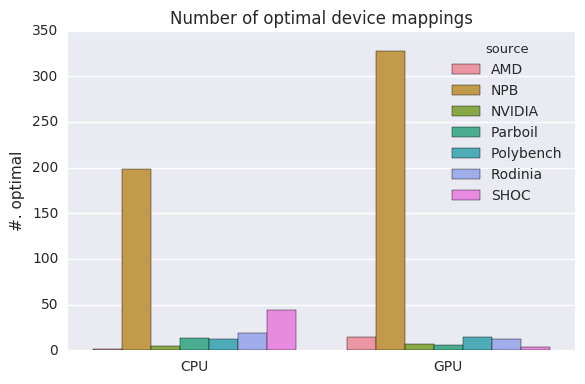

In [6]:
ax = sns.countplot(x="oracle_enc", data=dataframe, hue="source")
plt.title("Number of optimal device mappings")
plt.xticks([0, 1], ["CPU", "GPU"])
plt.xlabel("")
plt.ylabel("#. optimal")

num_oracle_gpu = sum(dataframe["oracle_enc"])
num_oracle_cpu = len(dataframe) - num_oracle_gpu
zero_r = "CPU" if num_oracle_cpu > num_oracle_gpu else "GPU"
acc_zero_r = max(num_oracle_cpu, num_oracle_gpu) / len(dataframe)

print("Accuracy of Zero-R ({zero_r}): {acc_zero_r:.2%}".format(**vars()))

viz.finalise(figsize=(6, 4))

min seq len 53
max seq len 24604
mean seq len 2650
25% percentile 290
50% percentile 538
60% percentile 724
75% percentile 1504
90% percentile 13449
padded seq len 1024
percentile of padded seq len 66.5%


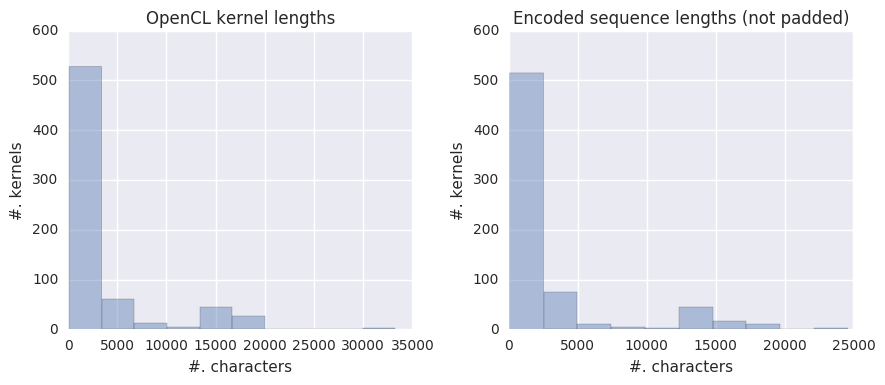

In [7]:
plt.subplot(1, 2, 1)
ax = sns.distplot(dataframe["src_len"], kde=None, bins=10)
plt.title("OpenCL kernel lengths")
plt.xlabel("#. characters")
plt.ylabel("#. kernels")

plt.subplot(1, 2, 2)
ax = sns.distplot(dataframe["seq_len"], kde=None, bins=10)
plt.title("Encoded sequence lengths (not padded)")
plt.xlabel("#. characters")
plt.ylabel("#. kernels")

print("min seq len", min(dataframe["seq_len"]))
print("max seq len", max(dataframe["seq_len"]))
print("mean seq len", int(round(np.mean(dataframe["seq_len"]))))
for p in [25, 50, 60, 75, 90]:
    print("{p}% percentile".format(p=p), int(np.percentile(dataframe["seq_len"], p)))
print("padded seq len", seq_length)
print("percentile of padded seq len {:.1f}%".format(
    percentileofscore(dataframe["seq_len"], seq_length, 'mean')))

viz.finalise(figsize=(9, 4))

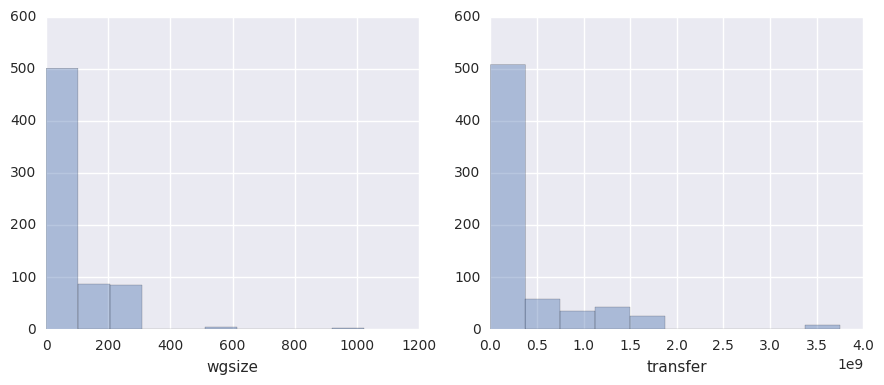

In [8]:
plt.subplot(1, 2, 1)
ax = sns.distplot(dataframe["wgsize"], kde=None, bins=10)
plt.subplot(1, 2, 2)
ax = sns.distplot(dataframe["transfer"], kde=None, bins=10)
viz.finalise(figsize=(9, 4))

## Source + dynamic props classification

In [9]:
def analyze(predictions, test):
    def enc2key(p):
        return "runtime_gpu" if p else "runtime_cpu"
    
    frame = test["dataframe"]
    oracle = np.array(frame["oracle_enc"], dtype=np.bool)
    incorrect = np.logical_xor(predictions, oracle)
    correct = np.logical_not(incorrect)

    zero_r = Counter(oracle).most_common(1)[0][0]
    zero_r_key = enc2key(zero_r)
    
    speedups = np.array([min(d["runtime_cpu"], d["runtime_gpu"]) / d[enc2key(p)]
                         for p,d in zip(predictions, frame.T.to_dict().values())])
    speedup_avg = speedups.mean()
    speedup_geo = gmean(speedups)
    
    accuracy = sum(correct) / len(test["dataframe"])
    
    confusion_matrix = np.zeros((2, 2), dtype="int32")
    confusion_matrix[0][0] = sum(np.logical_and(np.logical_not(predictions), np.logical_not(oracle)))
    confusion_matrix[0][1] = sum(np.logical_and(predictions, np.logical_not(oracle)))
    confusion_matrix[1][0] = sum(np.logical_and(np.logical_not(predictions), oracle))
    confusion_matrix[1][1] = sum(np.logical_and(predictions, oracle))
    
    assert(confusion_matrix.sum() == len(test["dataframe"]))
    assert(confusion_matrix[0][1] + confusion_matrix[1][1] == sum(predictions))
    assert(confusion_matrix[0][1] + confusion_matrix[1][0] == sum(incorrect))
    assert(confusion_matrix[0][0] + confusion_matrix[1][1] == sum(correct))
    print(confusion_matrix)
    
    return {
        "accuracy": accuracy,
        "confusion_matrix": confusion_matrix,
        # "speedups": speedups,
        "speedup_min": min(speedups),
        "speedup_max": max(speedups),
        "speedup_avg": speedup_avg,
        "speedup_geo": speedup_geo,
    }

In [10]:
def evaluate(dataframe, seq_length, create_model, train_fn, test_fn, seed=1, save_fn=None, split=(.6, .2, .2), n=5, quiet=False):
    """
    Arguments:
        create_model (function): Function with definition:
                create_model(seed, i) -> model
        train_fn (function): Function with definition:
                train_fn(seed, model, train_data, validation_data) -> {}
        save_fn (function): Function with definition:
                save_fn(seed, i, model) -> None
        test_fn (function): Function with definition:
                test_fn(seed, model, test_data) -> {}
        n (int): Number of repetitions
    
    Returns:
        list: list of length n, each element a pair of train_fn(), test_fn() return values
    """
    train_results = []
    test_results = []
    for i in range(n):
        j = i + 1
        # get training_data
        train, validation, test = get_training_data(dataframe, seed + i, seq_length, i=i, n=n, split=split)
        # create model
        model = create_model(i=i, seed=seed + i)
        # train model
        start = time.time()
        train_result = train_fn(model=model, train=train, validation=validation, i=i, seed=seed + i) or {}
        elapsed = time.time() - start
        train_result["time"] = elapsed
        m = len(train["y"])
        #if elapsed > 3:
        if not quiet:
            print("[{j:2} of {n}] training on {m} instances took {elapsed:.2f}s".format(**vars()))
        train_results.append(train_result)
        # save model
        if save_fn is not None:
            save_fn(model=model, i=i, n=n, seed=seed + i)
        # make predictions
        start = time.time()
        predictions = test_fn(model=model, test=test, i=i, seed=seed + i)
        elapsed = time.time() - start
        test_result = analyze(predictions, test)
        test_result["time"] = elapsed
        accuracy = test_result["accuracy"]
        geo_speedup = test_result["speedup_geo"]
        m = len(test["y"])
        
        if not quiet:
            print("[{j:2} of {n}] accuracy on {m} test instances: {accuracy:.2%}, speedup {geo_speedup:.2}x (elapsed {elapsed:.2f}s)".format(**vars()))
        test_results.append(test_result)

        del model
    
    # accuracy
    a = np.array([x["accuracy"] for x in test_results])
    mean_acc = a.mean()
    std = a.std()
    
    a = np.array([x["speedup_geo"] for x in test_results])
    geo_speedup = gmean(a)
    std_speedup = a.std()
    
    # times
    a = np.array([x["time"] for x in train_results])
    mean_train_time = a.mean()
    std_train_time = a.std()
    
    a = np.array([x["time"] for x in test_results])
    mean_eval_time = a.mean()
    std_eval_time = a.std()
    
    if not quiet:
        print()
    print("avg training time {mean_train_time:.2f}s, eval time {mean_eval_time:.2f}s".format(**vars()))
    print("avg accuracy {mean_acc:.2%} (std: {std:.2%}), oracle {geo_speedup:.2f}x (std: {std_speedup:.2%})".format(**vars()))
    return train_results, test_results

In [12]:
def run_experiments(platform, source, *args, **kwargs):
    print("PLATFORM", platform, "SOURCE", source)
    dataframe, seq_length, atomizer = load_dataframe(
        platform=platform,
        source=source,
        max_seq_len=1024, 
        # atomizer=GreedyAtomizer
        atomizer=CharacterAtomizer
    )

    x_2 = get_2(dataframe)
    x_4 = get_4(dataframe)
    x_11 = get_11(dataframe)
    x_seq = get_sequences(dataframe, seq_length)
    y = get_labels(dataframe)

    vocab_size = atomizer.vocab_size + 1  # +1 for pad value
    
    results = evaluate(dataframe, seq_length, *args, **kwargs)
    print()
    return (np.array([x["accuracy"] for x in results[1]]).mean(), gmean(np.array(
        [x["speedup_geo"] for x in results[1]])))

In [13]:
def experiments(*args, **kwargs):
    acc = []
    oracles = []
    a, o = run_experiments("amd", "N", *args, **kwargs)
    acc.append(a); oracles.append(o)
    a, o = run_experiments("amd", "B", *args, **kwargs)
    acc.append(a); oracles.append(o)
    a, o = run_experiments("amd", "S", *args, **kwargs)
    acc.append(a); oracles.append(o)
    a, o = run_experiments("amd", "BS", *args, **kwargs)
    acc.append(a); oracles.append(o)
    a, o = run_experiments("nvidia", "N", *args, **kwargs)
    acc.append(a); oracles.append(o)
    a, o = run_experiments("nvidia", "B", *args, **kwargs)
    acc.append(a); oracles.append(o)
    a, o = run_experiments("nvidia", "S", *args, **kwargs)
    acc.append(a); oracles.append(o)
    a, o = run_experiments("nvidia", "BS", *args, **kwargs)
    acc.append(a); oracles.append(o)

    print("************")
    print("            amd: [B, S, BS] nvidia: [B, S, BS]")
    print("Accuracies:", ", ".join(["{:.1%}".format(x) for x in acc]))
    print("Oracles:  ", ", ".join(["{:.2f}x".format(x) for x in oracles]))
    return acc, oracles

### Zero-R

In [ ]:
def create_model(seed=seed, **kwargs):
    np.random.seed(seed)
    return {}

def train_fn(model, train, validation, *args, **kwargs):
    np.random.seed(seed)
    model["zero_r"] = Counter(train["y"][:,0]).most_common(1)[0][0]
    return {}
    
def test_fn(model, test, seed, *args, **kwargs):
    np.random.seed(seed)
    return [model["zero_r"]] * len(test["y"])

# r = evaluate(dataframe, seq_length, create_model, train_fn, test_fn, split=(.6, .2, .2), seed=204, n=10)
r = experiments(create_model, train_fn, test_fn, split=(.6, .2, .2), seed=204, n=10, quiet=True)

### CGO'13 model

In [41]:
def create_model(seed=seed, **kwargs):
    np.random.seed(seed)
    return DecisionTreeClassifier(random_state=seed, splitter="best", criterion="entropy")

def train_fn(model, train, validation, *args, **kwargs):
    np.random.seed(seed)
    model.fit(train["x_4"], train["y"])
    return {}
    
def test_fn(model, test, seed, *args, **kwargs):
    np.random.seed(seed)
    return model.predict(test["x_4"])

r = evaluate(dataframe, seq_length, create_model, train_fn, test_fn, split=(.6, .2, .2), seed=204, n=3)
# r = experiments(create_model, train_fn, test_fn, split=(.6, .2, .2), seed=204, n=10, quiet=True)

[ 1 of 3] training on 9553 instances took 0.01s
[[1834  125]
 [ 194 1019]]
[ 1 of 3] accuracy on 3172 test instances: 89.94%, speedup 0.68x (elapsed 0.00s)
[ 2 of 3] training on 9458 instances took 0.01s
[[1840  118]
 [ 182 1040]]
[ 2 of 3] accuracy on 3180 test instances: 90.57%, speedup 0.68x (elapsed 0.00s)
[ 3 of 3] training on 9540 instances took 0.01s
[[1916  115]
 [ 194 1050]]
[ 3 of 3] accuracy on 3275 test instances: 90.56%, speedup 0.68x (elapsed 0.00s)

avg training time 0.01s, eval time 0.00s
avg accuracy 90.36% (std: 0.29%), oracle 0.68x (std: 0.12%)


### CGO'13 Model (only dynprops)

In [42]:
def create_model(*args, seed=None, **kwargs):
    np.random.seed(seed)
    return DecisionTreeClassifier(random_state=seed, splitter="best", criterion="entropy")

def train_fn(model, train, validation, seed, *args, **kwargs):
    np.random.seed(seed)
    model.fit(train["x_2"], train["y"])
    return {}
    
def test_fn(model, test, *args, seed=None, **kwargs):
    np.random.seed(seed)
    return model.predict(test["x_2"])

r = evaluate(dataframe, seq_length, create_model, train_fn, test_fn, split=(.6, .2, .2), seed=204, n=3)
# r = experiments(create_model, train_fn, test_fn, split=(.6, .2, .2), seed=204, n=10, quiet=True)

[ 1 of 3] training on 9553 instances took 0.00s
[[1871   88]
 [ 166 1047]]
[ 1 of 3] accuracy on 3172 test instances: 91.99%, speedup 0.68x (elapsed 0.00s)
[ 2 of 3] training on 9458 instances took 0.00s
[[1868   90]
 [ 141 1081]]
[ 2 of 3] accuracy on 3180 test instances: 92.74%, speedup 0.68x (elapsed 0.00s)
[ 3 of 3] training on 9540 instances took 0.00s
[[1942   89]
 [ 154 1090]]
[ 3 of 3] accuracy on 3275 test instances: 92.58%, speedup 0.68x (elapsed 0.00s)

avg training time 0.00s, eval time 0.00s
avg accuracy 92.44% (std: 0.32%), oracle 0.68x (std: 0.04%)


**Effect of split size on accuracy:**

In [ ]:
%%capture
splits = [(x, (1-x)/2, (1-x)/2) for x in np.arange(0.05,.975,0.025)]
results = list(zip(
    splits, [evaluate(dataframe, seq_length, create_model, train_fn, test_fn, split=split, seed=204, n=10) for split in splits]))

In [ ]:
# TODO:
# y = [np.array([x["accuracy"] * 100 for x in r[1][1]]) for r in results]
# sns.tsplot(data=y)

x = [r[0][2] * 100 for r in results]
y = [np.array([x["accuracy"] * 100 for x in r[1][1]]).mean() for r in results]
err = [np.array([x["accuracy"] * 100 for x in r[1][1]]).std() for r in results]
plt.plot(x, y, color="b")
plt.errorbar(x, y, yerr=err, color="b", fmt='o', ecolor='k', capthick=1)

plt.xlabel("Ratio of unseen data (%)")
plt.ylabel("Accuracy (%)")

viz.finalise(figsize=(5, 5))

### Baseline model (only dynprops)

In [ ]:
# TODO: batch norm after merge, not before
# TODO: another layer of LSTM
# TODO: Dropout?
# TODO: activations: rely, sigmoid, softmax, tanh

def create_model(*args, seed=None, **kwargs):
    np.random.seed(seed)

    model = Sequential()
    # model.add(BatchNormalization(input_shape=(2,), name="dynprop_norm"))
    model.add(Dense(32, input_shape=(2,), init='normal', activation="relu"))
    model.add(Dropout(0.15))
    model.add(Dense(16, init='normal', activation="relu"))
#     model.add(Dropout(0.15))
#     model.add(Dense(16, init='normal', activation="relu"))
#     model.add(Dropout(0.15))
    model.add(Dense(2, init='normal', activation='softmax', name="output"))

    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    return model

def train_fn(model, train, validation, seed, *args, **kwargs):
    np.random.seed(seed)
    model.fit(train["x_2"].astype(np.int32), train["y_2"].astype(np.int32),
              nb_epoch=10,
              validation_data=(validation["x_2"].astype(np.int32), validation["y_2"].astype(np.int32)),
              verbose=0)
    return {}

def test_fn(model, test, seed, *args, **kwargs):
    np.random.seed(seed)
    predictions = model.predict(test["x_2"].astype(np.int32), verbose=0)
#     sns.distplot(predictions[:,0], kde=None)
#     viz.finalise()
#     sns.distplot(predictions[:,1], kde=None)
#     viz.finalise()

    clipped = np.array([np.argmax(x) for x in predictions], dtype=np.int32)
    # print(sum(clipped), len(clipped) - sum(clipped))
    return clipped

# r = evaluate(dataframe, seq_length, create_model, train_fn, test_fn, split=(.6, .2, .2), seed=204, n=10)
r = experiments(create_model, train_fn, test_fn, split=(.6, .2, .2), seed=204, n=10, quiet=True)

In [ ]:
model = create_model()
model.summary()
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [38]:
# TEST ON NVIDIA B
def create_model(*args, seed=None, **kwargs):
    np.random.seed(seed)
    model = Sequential()
    model.add(BatchNormalization(input_shape=(2,), name="dynprop_norm"))
    model.add(Dense(4))
    model.add(Dense(2, name="output"))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

def train_fn(model, train, validation, seed, *args, **kwargs):
    np.random.seed(seed)
    model.fit(train["x_2"], train["y_2"], validation_data=(validation["x_2"], validation["y_2"]),
              nb_epoch=10,
              verbose=0)
    return {}

def test_fn(model, test, seed, *args, **kwargs):
    np.random.seed(seed)
    predictions = model.predict(test["x_2"], verbose=0)
    clipped = np.array([np.argmax(x) for x in predictions], dtype=np.int32)
    return clipped

r = evaluate(dataframe, seq_length, create_model, train_fn, test_fn, split=(.6, .2, .2), seed=204, n=3)

[ 1 of 3] training on 397 instances took 2.87s
[[25 31]
 [56 33]]
[ 1 of 3] accuracy on 145 test instances: 40.00%, speedup 0.6x (elapsed 1.17s)
[ 2 of 3] training on 378 instances took 2.90s
[[27 33]
 [43 25]]
[ 2 of 3] accuracy on 128 test instances: 40.62%, speedup 0.57x (elapsed 1.27s)
[ 3 of 3] training on 420 instances took 2.97s
[[31 27]
 [37 36]]
[ 3 of 3] accuracy on 131 test instances: 51.15%, speedup 0.66x (elapsed 1.24s)

avg training time 2.91s, eval time 1.23s
avg accuracy 43.92% (std: 5.11%), oracle 0.61x (std: 3.53%)


In [48]:
# TEST 3a, AMD S:
def create_model(*args, seed=None, **kwargs):
    np.random.seed(seed)
    model = Sequential()
    model.add(BatchNormalization(input_shape=(11,), name="dynprop_norm"))
    model.add(Dense(11, activation="relu"))
    model.add(Dense(2, activation="sigmoid", name="output"))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

def train_fn(model, train, validation, seed, *args, **kwargs):
    np.random.seed(seed)
    model.fit(train["x_11"], train["y_2"], validation_data=(validation["x_11"], validation["y_2"]),
              nb_epoch=10,
              verbose=0)
    return {}

def test_fn(model, test, seed, *args, **kwargs):
    np.random.seed(seed)
    predictions = model.predict(test["x_11"], verbose=0)
    clipped = np.array([np.argmax(x) for x in predictions], dtype=np.int32)
    return clipped

dataframe, seq_length, atomizer = load_dataframe(
    platform="amd",
    source="S"
)
r = evaluate(dataframe, seq_length, create_model, train_fn, test_fn, split=(.6, .2, .2), seed=204, n=3)

[ 1 of 3] training on 9553 instances took 19.82s
[[ 998  405]
 [ 234 1535]]
[ 1 of 3] accuracy on 3172 test instances: 79.85%, speedup 0.71x (elapsed 1.67s)
[ 2 of 3] training on 9458 instances took 19.55s
[[1056  376]
 [ 214 1534]]
[ 2 of 3] accuracy on 3180 test instances: 81.45%, speedup 0.7x (elapsed 1.62s)
[ 3 of 3] training on 9540 instances took 19.57s
[[1178  283]
 [ 269 1545]]
[ 3 of 3] accuracy on 3275 test instances: 83.15%, speedup 0.7x (elapsed 1.67s)

avg training time 19.65s, eval time 1.65s
avg accuracy 81.48% (std: 1.34%), oracle 0.70x (std: 0.32%)


In [53]:
# TEST 3b, NVIDIA S:
def create_model(*args, seed=None, **kwargs):
    np.random.seed(seed)
    model = Sequential()
    model.add(BatchNormalization(input_shape=(11,), name="dynprop_norm"))
    model.add(Dense(11, activation="relu"))
    model.add(Dense(2, activation="sigmoid", name="output"))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

def train_fn(model, train, validation, seed, *args, **kwargs):
    np.random.seed(seed)
    model.fit(train["x_11"], train["y_2"], validation_data=(validation["x_11"], validation["y_2"]),
              nb_epoch=10,
              verbose=0)
    return {}

def test_fn(model, test, seed, *args, **kwargs):
    np.random.seed(seed)
    predictions = model.predict(test["x_11"], verbose=0)
    clipped = np.array([np.argmax(x) for x in predictions], dtype=np.int32)
    return clipped

dataframe, seq_length, atomizer = load_dataframe(
    platform="nvidia",
    source="S"
)
r = evaluate(dataframe, seq_length, create_model, train_fn, test_fn, split=(.6, .2, .2), seed=204, n=3)

num instances 15919 (15919 synthetic, 0 benchmarks)
unique kernels 1000
vocab size 69
pad val 69
padded seq length 658
[ 1 of 3] training on 9553 instances took 20.32s
[[1557  402]
 [  97 1116]]
[ 1 of 3] accuracy on 3172 test instances: 84.27%, speedup 0.67x (elapsed 1.80s)
[ 2 of 3] training on 9458 instances took 20.10s
[[1680  278]
 [  95 1127]]
[ 2 of 3] accuracy on 3180 test instances: 88.27%, speedup 0.67x (elapsed 1.80s)
[ 3 of 3] training on 9540 instances took 20.34s
[[1668  363]
 [  84 1160]]
[ 3 of 3] accuracy on 3275 test instances: 86.35%, speedup 0.67x (elapsed 1.88s)

avg training time 20.25s, eval time 1.82s
avg accuracy 86.30% (std: 1.63%), oracle 0.67x (std: 0.07%)


In [54]:
# TEST 3c, AMD B:
def create_model(*args, seed=None, **kwargs):
    np.random.seed(seed)
    model = Sequential()
    model.add(BatchNormalization(input_shape=(11,), name="dynprop_norm"))
    model.add(Dense(11, activation="relu"))
    model.add(Dense(2, activation="sigmoid", name="output"))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

def train_fn(model, train, validation, seed, *args, **kwargs):
    np.random.seed(seed)
    model.fit(train["x_11"], train["y_2"], validation_data=(validation["x_11"], validation["y_2"]),
              nb_epoch=10,
              verbose=0)
    return {}

def test_fn(model, test, seed, *args, **kwargs):
    np.random.seed(seed)
    predictions = model.predict(test["x_11"], verbose=0)
    clipped = np.array([np.argmax(x) for x in predictions], dtype=np.int32)
    return clipped

dataframe, seq_length, atomizer = load_dataframe(
    platform="amd",
    source="B"
)
r = evaluate(dataframe, seq_length, create_model, train_fn, test_fn, split=(.6, .2, .2), seed=204, n=3)

num instances 680 (0 synthetic, 680 benchmarks)
unique kernels 247
vocab size 84
pad val 84
padded seq length 1000
[ 1 of 3] training on 397 instances took 3.40s
[[73  6]
 [51 15]]
[ 1 of 3] accuracy on 145 test instances: 60.69%, speedup 0.57x (elapsed 1.63s)
[ 2 of 3] training on 378 instances took 3.41s
[[66  7]
 [25 30]]
[ 2 of 3] accuracy on 128 test instances: 75.00%, speedup 0.53x (elapsed 1.64s)
[ 3 of 3] training on 420 instances took 3.46s
[[60 17]
 [26 28]]
[ 3 of 3] accuracy on 131 test instances: 67.18%, speedup 0.57x (elapsed 1.67s)

avg training time 3.42s, eval time 1.65s
avg accuracy 67.62% (std: 5.85%), oracle 0.56x (std: 1.84%)


In [55]:
# TEST 3d, NVIDIA B:
def create_model(*args, seed=None, **kwargs):
    np.random.seed(seed)
    model = Sequential()
    model.add(BatchNormalization(input_shape=(11,), name="dynprop_norm"))
    model.add(Dense(11, activation="relu"))
    model.add(Dense(2, activation="sigmoid", name="output"))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

def train_fn(model, train, validation, seed, *args, **kwargs):
    np.random.seed(seed)
    model.fit(train["x_11"], train["y_2"], validation_data=(validation["x_11"], validation["y_2"]),
              nb_epoch=10,
              verbose=0)
    return {}

def test_fn(model, test, seed, *args, **kwargs):
    np.random.seed(seed)
    predictions = model.predict(test["x_11"], verbose=0)
    clipped = np.array([np.argmax(x) for x in predictions], dtype=np.int32)
    return clipped

dataframe, seq_length, atomizer = load_dataframe(
    platform="nvidia",
    source="B"
)
r = evaluate(dataframe, seq_length, create_model, train_fn, test_fn, split=(.6, .2, .2), seed=204, n=3)

num instances 680 (0 synthetic, 680 benchmarks)
unique kernels 247
vocab size 84
pad val 84
padded seq length 1000
[ 1 of 3] training on 397 instances took 3.49s
[[14 42]
 [22 67]]
[ 1 of 3] accuracy on 145 test instances: 55.86%, speedup 0.67x (elapsed 1.63s)
[ 2 of 3] training on 378 instances took 3.49s
[[14 46]
 [ 2 66]]
[ 2 of 3] accuracy on 128 test instances: 62.50%, speedup 0.61x (elapsed 1.65s)
[ 3 of 3] training on 420 instances took 3.67s
[[22 36]
 [ 8 65]]
[ 3 of 3] accuracy on 131 test instances: 66.41%, speedup 0.64x (elapsed 1.74s)

avg training time 3.55s, eval time 1.67s
avg accuracy 61.59% (std: 4.35%), oracle 0.64x (std: 2.17%)


In [56]:
# TEST 3e, AMD BS:
def create_model(*args, seed=None, **kwargs):
    np.random.seed(seed)
    model = Sequential()
    model.add(BatchNormalization(input_shape=(11,), name="dynprop_norm"))
    model.add(Dense(11, activation="relu"))
    model.add(Dense(2, activation="sigmoid", name="output"))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

def train_fn(model, train, validation, seed, *args, **kwargs):
    np.random.seed(seed)
    model.fit(train["x_11"], train["y_2"], validation_data=(validation["x_11"], validation["y_2"]),
              nb_epoch=10,
              verbose=0)
    return {}

def test_fn(model, test, seed, *args, **kwargs):
    np.random.seed(seed)
    predictions = model.predict(test["x_11"], verbose=0)
    clipped = np.array([np.argmax(x) for x in predictions], dtype=np.int32)
    return clipped

dataframe, seq_length, atomizer = load_dataframe(
    platform="amd",
    source="BS"
)
r = evaluate(dataframe, seq_length, create_model, train_fn, test_fn, split=(.6, .2, .2), seed=204, n=3)

num instances 16599 (15919 synthetic, 680 benchmarks)
unique kernels 1247
vocab size 84
pad val 84
padded seq length 1000
[ 1 of 3] training on 16316 instances took 28.95s
[[67  9]
 [39 24]]
[ 1 of 3] accuracy on 139 test instances: 65.47%, speedup 0.52x (elapsed 1.73s)
[ 2 of 3] training on 16297 instances took 28.74s
[[72 15]
 [22 35]]
[ 2 of 3] accuracy on 144 test instances: 74.31%, speedup 0.53x (elapsed 1.67s)
[ 3 of 3] training on 16339 instances took 30.20s
[[52 19]
 [25 32]]
[ 3 of 3] accuracy on 128 test instances: 65.62%, speedup 0.54x (elapsed 1.67s)

avg training time 29.30s, eval time 1.69s
avg accuracy 68.47% (std: 4.13%), oracle 0.53x (std: 0.92%)


In [57]:
# TEST 3f, NVIDIA BS:
def create_model(*args, seed=None, **kwargs):
    np.random.seed(seed)
    model = Sequential()
    model.add(BatchNormalization(input_shape=(11,), name="dynprop_norm"))
    model.add(Dense(11, activation="relu"))
    model.add(Dense(2, activation="sigmoid", name="output"))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

def train_fn(model, train, validation, seed, *args, **kwargs):
    np.random.seed(seed)
    model.fit(train["x_11"], train["y_2"], validation_data=(validation["x_11"], validation["y_2"]),
              nb_epoch=10,
              verbose=0)
    return {}

def test_fn(model, test, seed, *args, **kwargs):
    np.random.seed(seed)
    predictions = model.predict(test["x_11"], verbose=0)
    clipped = np.array([np.argmax(x) for x in predictions], dtype=np.int32)
    return clipped

dataframe, seq_length, atomizer = load_dataframe(
    platform="nvidia",
    source="BS"
)
r = evaluate(dataframe, seq_length, create_model, train_fn, test_fn, split=(.6, .2, .2), seed=204, n=3)

num instances 16599 (15919 synthetic, 680 benchmarks)
unique kernels 1247
vocab size 84
pad val 84
padded seq length 1000
[ 1 of 3] training on 16316 instances took 29.10s
[[36 14]
 [68 21]]
[ 1 of 3] accuracy on 139 test instances: 41.01%, speedup 0.48x (elapsed 1.81s)
[ 2 of 3] training on 16297 instances took 29.09s
[[57  0]
 [84  3]]
[ 2 of 3] accuracy on 144 test instances: 41.67%, speedup 0.45x (elapsed 1.71s)
[ 3 of 3] training on 16339 instances took 29.22s
[[43 15]
 [53 17]]
[ 3 of 3] accuracy on 128 test instances: 46.88%, speedup 0.58x (elapsed 1.80s)

avg training time 29.14s, eval time 1.77s
avg accuracy 43.18% (std: 2.62%), oracle 0.50x (std: 5.56%)


### Tweaks

In [60]:
# TEST 4, CGO'13
def create_model(seed=seed, **kwargs):
    np.random.seed(seed)
    return DecisionTreeClassifier(random_state=seed, splitter="best", criterion="entropy")

def train_fn(model, train, validation, *args, **kwargs):
    np.random.seed(seed)
    model.fit(train["x_4"], train["y"])
    return {}
    
def test_fn(model, test, seed, *args, **kwargs):
    np.random.seed(seed)
    return model.predict(test["x_4"])

dataframe, seq_length, atomizer = load_dataframe(
    platform="amd",
    source="B"
)
r = evaluate(dataframe, seq_length, create_model, train_fn, test_fn, split=(.6, .2, .2), seed=204, n=3)
print()
dataframe, seq_length, atomizer = load_dataframe(
    platform="nvidia",
    source="B"
)
r = evaluate(dataframe, seq_length, create_model, train_fn, test_fn, split=(.6, .2, .2), seed=204, n=3)

num instances 680 (0 synthetic, 680 benchmarks)
unique kernels 247
vocab size 84
pad val 84
padded seq length 1000
[ 1 of 3] training on 397 instances took 0.00s
[[70  9]
 [17 49]]
[ 1 of 3] accuracy on 145 test instances: 82.07%, speedup 0.56x (elapsed 0.00s)
[ 2 of 3] training on 378 instances took 0.00s
[[56 17]
 [13 42]]
[ 2 of 3] accuracy on 128 test instances: 76.56%, speedup 0.5x (elapsed 0.00s)
[ 3 of 3] training on 420 instances took 0.00s
[[71  6]
 [16 38]]
[ 3 of 3] accuracy on 131 test instances: 83.21%, speedup 0.54x (elapsed 0.00s)

avg training time 0.00s, eval time 0.00s
avg accuracy 80.61% (std: 2.90%), oracle 0.53x (std: 2.32%)
num instances 680 (0 synthetic, 680 benchmarks)
unique kernels 247
vocab size 84
pad val 84
padded seq length 1000
[ 1 of 3] training on 397 instances took 0.00s
[[48  8]
 [16 73]]
[ 1 of 3] accuracy on 145 test instances: 83.45%, speedup 0.58x (elapsed 0.00s)
[ 2 of 3] training on 378 instances took 0.00s
[[49 11]
 [13 55]]
[ 2 of 3] accuracy 

In [64]:
# TEST 4a, AMD B:
def create_model(*args, seed=None, **kwargs):
    np.random.seed(seed)
    model = Sequential()
    model.add(BatchNormalization(input_shape=(2,), name="dynprop_norm"))
    model.add(Dense(11, activation="relu"))
    model.add(Dense(2, activation="sigmoid", name="output"))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

def train_fn(model, train, validation, seed, *args, **kwargs):
    np.random.seed(seed)
    model.fit(train["x_2"], train["y_2"], validation_data=(validation["x_2"], validation["y_2"]),
              nb_epoch=10,
              verbose=0)
    return {}

def test_fn(model, test, seed, *args, **kwargs):
    np.random.seed(seed)
    predictions = model.predict(test["x_2"], verbose=0)
    clipped = np.array([np.argmax(x) for x in predictions], dtype=np.int32)
    return clipped

dataframe, seq_length, atomizer = load_dataframe(
    platform="amd",
    source="B"
)
r = evaluate(dataframe, seq_length, create_model, train_fn, test_fn, split=(.6, .2, .2), seed=204, n=3)
print()
dataframe, seq_length, atomizer = load_dataframe(
    platform="nvidia",
    source="B"
)
r = evaluate(dataframe, seq_length, create_model, train_fn, test_fn, split=(.6, .2, .2), seed=204, n=3)

num instances 680 (0 synthetic, 680 benchmarks)
unique kernels 247
vocab size 84
pad val 84
padded seq length 1000
[ 1 of 3] training on 397 instances took 5.45s
[[72  7]
 [42 24]]
[ 1 of 3] accuracy on 145 test instances: 66.21%, speedup 0.57x (elapsed 2.03s)
[ 2 of 3] training on 378 instances took 3.98s
[[55 18]
 [12 43]]
[ 2 of 3] accuracy on 128 test instances: 76.56%, speedup 0.52x (elapsed 2.03s)
[ 3 of 3] training on 420 instances took 4.13s
[[62 15]
 [13 41]]
[ 3 of 3] accuracy on 131 test instances: 78.63%, speedup 0.51x (elapsed 2.12s)

avg training time 4.52s, eval time 2.06s
avg accuracy 73.80% (std: 5.43%), oracle 0.53x (std: 2.86%)

num instances 680 (0 synthetic, 680 benchmarks)
unique kernels 247
vocab size 84
pad val 84
padded seq length 1000
[ 1 of 3] training on 397 instances took 4.03s
[[15 41]
 [14 75]]
[ 1 of 3] accuracy on 145 test instances: 62.07%, speedup 0.62x (elapsed 2.16s)
[ 2 of 3] training on 378 instances took 4.07s
[[ 0 60]
 [ 0 68]]
[ 2 of 3] accurac

In [63]:
# TEST 4a, AMD B:
def create_model(*args, seed=None, **kwargs):
    np.random.seed(seed)
    model = Sequential()
    model.add(BatchNormalization(input_shape=(4,), name="dynprop_norm"))
    model.add(Dense(11, activation="relu"))
    model.add(Dense(2, activation="sigmoid", name="output"))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

def train_fn(model, train, validation, seed, *args, **kwargs):
    np.random.seed(seed)
    model.fit(train["x_4"], train["y_2"], validation_data=(validation["x_4"], validation["y_2"]),
              nb_epoch=10,
              verbose=0)
    return {}

def test_fn(model, test, seed, *args, **kwargs):
    np.random.seed(seed)
    predictions = model.predict(test["x_4"], verbose=0)
    clipped = np.array([np.argmax(x) for x in predictions], dtype=np.int32)
    return clipped

dataframe, seq_length, atomizer = load_dataframe(
    platform="amd",
    source="B"
)
r = evaluate(dataframe, seq_length, create_model, train_fn, test_fn, split=(.6, .2, .2), seed=204, n=3)
print()
dataframe, seq_length, atomizer = load_dataframe(
    platform="nvidia",
    source="B"
)
r = evaluate(dataframe, seq_length, create_model, train_fn, test_fn, split=(.6, .2, .2), seed=204, n=3)

num instances 680 (0 synthetic, 680 benchmarks)
unique kernels 247
vocab size 84
pad val 84
padded seq length 1000
[ 1 of 3] training on 397 instances took 3.97s
[[76  3]
 [51 15]]
[ 1 of 3] accuracy on 145 test instances: 62.76%, speedup 0.54x (elapsed 1.96s)
[ 2 of 3] training on 378 instances took 3.96s
[[56 17]
 [37 18]]
[ 2 of 3] accuracy on 128 test instances: 57.81%, speedup 0.56x (elapsed 1.93s)
[ 3 of 3] training on 420 instances took 3.97s
[[70  7]
 [34 20]]
[ 3 of 3] accuracy on 131 test instances: 68.70%, speedup 0.57x (elapsed 2.00s)

avg training time 3.96s, eval time 1.96s
avg accuracy 63.09% (std: 4.45%), oracle 0.56x (std: 1.17%)

num instances 680 (0 synthetic, 680 benchmarks)
unique kernels 247
vocab size 84
pad val 84
padded seq length 1000
[ 1 of 3] training on 397 instances took 3.96s
[[10 46]
 [18 71]]
[ 1 of 3] accuracy on 145 test instances: 55.86%, speedup 0.73x (elapsed 1.98s)
[ 2 of 3] training on 378 instances took 3.93s
[[14 46]
 [ 9 59]]
[ 2 of 3] accurac

In [61]:
# TEST 4a, NN:
def create_model(*args, seed=None, **kwargs):
    np.random.seed(seed)
    model = Sequential()
    model.add(BatchNormalization(input_shape=(11,), name="dynprop_norm"))
    model.add(Dense(11, activation="relu"))
    model.add(Dense(2, activation="sigmoid", name="output"))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

def train_fn(model, train, validation, seed, *args, **kwargs):
    np.random.seed(seed)
    model.fit(train["x_11"], train["y_2"], validation_data=(validation["x_11"], validation["y_2"]),
              nb_epoch=10,
              verbose=0)
    return {}

def test_fn(model, test, seed, *args, **kwargs):
    np.random.seed(seed)
    predictions = model.predict(test["x_11"], verbose=0)
    clipped = np.array([np.argmax(x) for x in predictions], dtype=np.int32)
    return clipped

dataframe, seq_length, atomizer = load_dataframe(
    platform="amd",
    source="B"
)
r = evaluate(dataframe, seq_length, create_model, train_fn, test_fn, split=(.6, .2, .2), seed=204, n=3)
print()
dataframe, seq_length, atomizer = load_dataframe(
    platform="nvidia",
    source="B"
)
r = evaluate(dataframe, seq_length, create_model, train_fn, test_fn, split=(.6, .2, .2), seed=204, n=3)

num instances 680 (0 synthetic, 680 benchmarks)
unique kernels 247
vocab size 84
pad val 84
padded seq length 1000
[ 1 of 3] training on 397 instances took 3.74s
[[73  6]
 [51 15]]
[ 1 of 3] accuracy on 145 test instances: 60.69%, speedup 0.57x (elapsed 1.86s)
[ 2 of 3] training on 378 instances took 3.73s
[[66  7]
 [25 30]]
[ 2 of 3] accuracy on 128 test instances: 75.00%, speedup 0.53x (elapsed 1.87s)
[ 3 of 3] training on 420 instances took 3.90s
[[60 17]
 [26 28]]
[ 3 of 3] accuracy on 131 test instances: 67.18%, speedup 0.57x (elapsed 1.94s)

avg training time 3.79s, eval time 1.89s
avg accuracy 67.62% (std: 5.85%), oracle 0.56x (std: 1.84%)

num instances 680 (0 synthetic, 680 benchmarks)
unique kernels 247
vocab size 84
pad val 84
padded seq length 1000
[ 1 of 3] training on 397 instances took 3.81s
[[14 42]
 [22 67]]
[ 1 of 3] accuracy on 145 test instances: 55.86%, speedup 0.67x (elapsed 1.98s)
[ 2 of 3] training on 378 instances took 3.94s
[[14 46]
 [ 2 66]]
[ 2 of 3] accurac

### Now we're getting somewhere!

In [77]:
batch_size = 64

def create_model(*args, seed=None, **kwargs):
    np.random.seed(seed)
    embedding_vector_length = 64 # 64

    dyn_inputs = Input(shape=(2,), name="dynprop_in")
    left = BatchNormalization(name="dynprop_norm")(dyn_inputs)

    seq_inputs = Input(shape=(seq_length,), dtype="int32", name="seq_in")
    right = Embedding(output_dim=embedding_vector_length, input_dim=vocab_size, input_length=seq_length)(seq_inputs)
    right = LSTM(16, consume_less="mem")(right)
    right = BatchNormalization(input_shape=(32,), name="lstm_norm")(right)

    aux_out = Dense(2, activation="sigmoid", name="aux_out")(right)

    x = merge([left, right], mode="concat")
    x = Dense(18, activation="relu")(x)
#     x = Dense(32, activation="relu")(x)
#     x = Dense(32, activation="relu")(x)
    out = Dense(2, activation="sigmoid", name="out")(x)

    model = Model(input=[dyn_inputs, seq_inputs], output=[out, aux_out])
    model.compile(optimizer="adam",
                  loss={"out": "categorical_crossentropy", "aux_out": "categorical_crossentropy"},
                  loss_weights={"out": 1., "aux_out": .2},
                  metrics=['accuracy'])
    return model

def train_fn(model, train, validation, seed, *args, **kwargs):
    np.random.seed(seed)
    model.fit({"dynprop_in": train["x_2"], "seq_in": train["x_seq"]},
          {"out": train["y_2"], "aux_out": train["y_2"]},
          nb_epoch=10,
          batch_size=batch_size,
          validation_data=({"dynprop_in": validation["x_2"], "seq_in": validation["x_seq"]},
                           {"out": validation["y_2"], "aux_out": validation["y_2"]}),
          verbose=1,
          shuffle=True
    )
    return {}

def save_fn(model, seed, i, *args, **kwargs):
    outpath = "classification/models/model-{i}-{seed}.h5".format(**vars())
    model.save(outpath)
    print("saved model", outpath)

def test_fn(model, test, seed, *args, **kwargs):
    np.random.seed(seed)
    predictions = np.array(model.predict({"dynprop_in": test["x_2"], "seq_in": test["x_seq"]},
                                         batch_size=batch_size, verbose=0))
    clipped = [np.argmax(x) for x in predictions[0]]
    return clipped

dataframe, seq_length, atomizer = load_dataframe(
    platform="amd",
    source="B"
)
r = evaluate(dataframe, seq_length, create_model, train_fn, test_fn, split=(.6, .2, .2), seed=204, n=3)
print()
dataframe, seq_length, atomizer = load_dataframe(
    platform="nvidia",
    source="B"
)
r = evaluate(dataframe, seq_length, create_model, train_fn, test_fn,
             split=(.6, .2, .2), save_fn=save_fn, seed=204, n=3)

num instances 680 (0 synthetic, 680 benchmarks)
unique kernels 247
vocab size 84
pad val 84
padded seq length 1000
Train on 397 samples, validate on 138 samples
Epoch 1/10
397/397 [==============================] - 16s - loss: 0.8079 - out_loss: 0.6702 - aux_out_loss: 0.6888 - out_acc: 0.6096 - aux_out_acc: 0.5038 - val_loss: 0.9848 - val_out_loss: 0.8469 - val_aux_out_loss: 0.6894 - val_out_acc: 0.4855 - val_aux_out_acc: 0.5507

In [78]:
# Multi-input model (10 epoch, 32 embedding vector)
batch_size = 64

def create_model(*args, seed=None, **kwargs):
    np.random.seed(seed)
    embedding_vector_length = 32

    dyn_inputs = Input(shape=(2,), name="dynprop_in")
    left = BatchNormalization(name="dynprop_norm")(dyn_inputs)

    seq_inputs = Input(shape=(seq_length,), dtype="int32", name="seq_in")
    right = Embedding(output_dim=embedding_vector_length, input_dim=vocab_size, input_length=seq_length)(seq_inputs)
    right = LSTM(16, consume_less="mem")(right)
    right = BatchNormalization(input_shape=(32,), name="lstm_norm")(right)

    aux_out = Dense(2, activation="sigmoid", name="aux_out")(right)

    x = merge([left, right], mode="concat")
    x = Dense(18, activation="relu")(x)
    out = Dense(2, activation="sigmoid", name="out")(x)

    model = Model(input=[dyn_inputs, seq_inputs], output=[out, aux_out])
    model.compile(optimizer="adam",
                  loss={"out": "categorical_crossentropy", "aux_out": "categorical_crossentropy"},
                  loss_weights={"out": 1., "aux_out": .2},
                  metrics=['accuracy'])
    return model

def train_fn(model, train, validation, seed, *args, **kwargs):
    np.random.seed(seed)
    model.fit({"dynprop_in": train["x_2"], "seq_in": train["x_seq"]},
          {"out": train["y_2"], "aux_out": train["y_2"]},
          nb_epoch=10,
          batch_size=batch_size,
          validation_data=({"dynprop_in": validation["x_2"], "seq_in": validation["x_seq"]},
                           {"out": validation["y_2"], "aux_out": validation["y_2"]}),
          verbose=1,
          shuffle=True
    )
    return {}

def save_fn(model, seed, i, *args, **kwargs):
    outpath = "classification/models/model-{i}-{seed}.h5".format(**vars())
    model.save(outpath)
    print("saved model", outpath)

def test_fn(model, test, seed, *args, **kwargs):
    np.random.seed(seed)
    predictions = np.array(model.predict({"dynprop_in": test["x_2"], "seq_in": test["x_seq"]},
                                         batch_size=batch_size, verbose=0))
    clipped = [np.argmax(x) for x in predictions[0]]
    return clipped

dataframe, seq_length, atomizer = load_dataframe(
    platform="amd",
    source="B",
    max_seq_len=1024, 
    atomizer=GreedyAtomizer
)
r = evaluate(dataframe, seq_length, create_model, train_fn, test_fn, split=(.6, .2, .2), seed=204, n=3)
print()
dataframe, seq_length, atomizer = load_dataframe(
    platform="nvidia",
    source="B",
    max_seq_len=1024, 
    atomizer=GreedyAtomizer
)
r = evaluate(dataframe, seq_length, create_model, train_fn, test_fn,
             split=(.6, .2, .2), save_fn=save_fn, seed=204, n=3)

num instances 680 (0 synthetic, 680 benchmarks)
unique kernels 247
vocab size 84
pad val 84
padded seq length 1000
Train on 397 samples, validate on 138 samples
Epoch 1/10
397/397 [==============================] - 17s - loss: 0.8101 - out_loss: 0.6751 - aux_out_loss: 0.6752 - out_acc: 0.5668 - aux_out_acc: 0.5743 - val_loss: 0.9976 - val_out_loss: 0.8594 - val_aux_out_loss: 0.6909 - val_out_acc: 0.4855 - val_aux_out_acc: 0.5652

In [ ]:
# Multi-input model (50 epoch)
# Multi-input model (10 epoch, 32 embedding vector)
batch_size = 64

def create_model(*args, seed=None, **kwargs):
    np.random.seed(seed)
    embedding_vector_length = 32

    dyn_inputs = Input(shape=(2,), name="data_in")
    left = BatchNormalization(name="dynprop_norm")(dyn_inputs)

    seq_inputs = Input(shape=(seq_length,), dtype="int32", name="code_in")
    right = Embedding(output_dim=embedding_vector_length, input_dim=vocab_size, input_length=seq_length)(seq_inputs)
    right = LSTM(16, consume_less="mem")(right)
    right = BatchNormalization(input_shape=(32,), name="lstm_norm")(right)

    aux_out = Dense(2, activation="sigmoid", name="aux_out")(right)

    x = merge([left, right], mode="concat")
    x = Dense(18, activation="relu")(x)
    out = Dense(2, activation="sigmoid", name="out")(x)

    model = Model(input=[dyn_inputs, seq_inputs], output=[out, aux_out])
    model.compile(optimizer="adam",
                  loss={"out": "categorical_crossentropy", "aux_out": "categorical_crossentropy"},
                  loss_weights={"out": 1., "aux_out": .2},
                  metrics=['accuracy'])
    return model

def train_fn(model, train, validation, seed, *args, **kwargs):
    np.random.seed(seed)
    model.fit({"data_in": train["x_2"], "code_in": train["x_seq"]},
          {"out": train["y_2"], "aux_out": train["y_2"]},
          nb_epoch=50,
          batch_size=batch_size,
          validation_data=({"data_in": validation["x_2"], "code_in": validation["x_seq"]},
                           {"out": validation["y_2"], "aux_out": validation["y_2"]}),
          verbose=0,
          shuffle=True
    )
    return {}

def save_fn(model, seed, i, *args, **kwargs):
    outpath = "classification/models/model-{i}-{seed}.h5".format(**vars())
    model.save(outpath)
    print("saved model", outpath)

def test_fn(model, test, seed, *args, **kwargs):
    np.random.seed(seed)
    predictions = np.array(model.predict({"dynprop_in": test["x_2"], "seq_in": test["x_seq"]},
                                         batch_size=batch_size, verbose=0))
    clipped = [np.argmax(x) for x in predictions[0]]
    return clipped

dataframe, seq_length, atomizer = load_dataframe(
    platform="amd",
    source="B",
    max_seq_len=1024, 
    atomizer=GreedyAtomizer
)
r = evaluate(dataframe, seq_length, create_model, train_fn, test_fn, split=(.6, .2, .2), seed=204, n=3)
print()
dataframe, seq_length, atomizer = load_dataframe(
    platform="nvidia",
    source="B",
    max_seq_len=1024, 
    atomizer=GreedyAtomizer
)
r = evaluate(dataframe, seq_length, create_model, train_fn, test_fn,
             split=(.6, .2, .2), save_fn=save_fn, seed=204, n=3)

num instances 680 (0 synthetic, 680 benchmarks)
unique kernels 247


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
seq_in (InputLayer)              (None, 1000)          0                                            
____________________________________________________________________________________________________
embedding_35 (Embedding)         (None, 1000, 32)      3200        seq_in[0][0]                     
____________________________________________________________________________________________________
dynprop_in (InputLayer)          (None, 2)             0                                            
____________________________________________________________________________________________________
lstm_35 (LSTM)                   (None, 16)            3136        embedding_35[0][0]               
___________________________________________________________________________________________

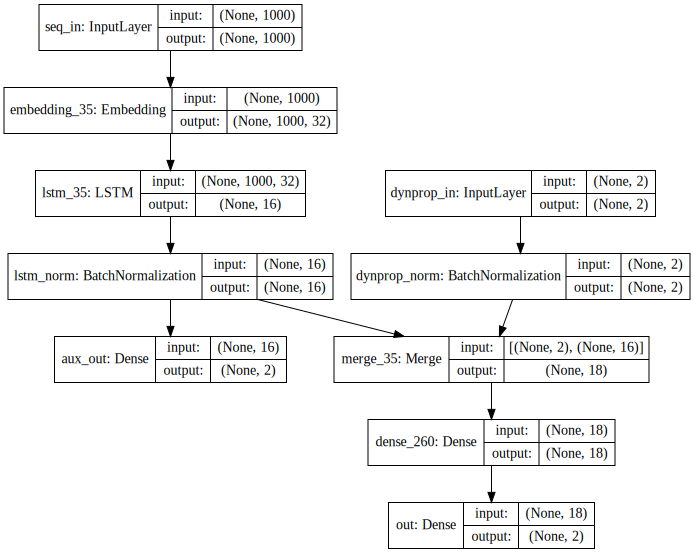

In [79]:
model = create_model()
model.summary()
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))